# Figure 2 - Supplemental (CMI Convergence and other information-retrieval statistics Figures)

Here, we demonstrate convergence of Co-MIGHT to the true CMI for a variety of different settings.

In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import math
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score

from sktree.stats.utils import (
    METRIC_FUNCTIONS,
    POSITIVE_METRICS,
    POSTERIOR_FUNCTIONS,
    REGRESSOR_METRICS,
    _compute_null_distribution_coleman,
    _mutual_information,
    _non_nan_samples,
)

seed = 12345
rng = np.random.default_rng(seed)

# Plotting partial-AUC over dimensionality of X2

In [3]:
sim_type = "directindirect"

In [4]:
if sim_type == "independent":
    df = pd.read_csv(
        "~/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_independent_model_fullv2.csv",
        index_col=0,
        header=0,
    )
elif sim_type == "collider":
    df = pd.read_csv(
        "~/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_collider_model_fullv2.csv",
        index_col=0,
        header=0,
    )
elif sim_type == "confounder":
    df = pd.read_csv(
        "~/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_confounder_model_fullv2.csv",
        index_col=0,
        header=0,
    )
elif sim_type == "directindirect":
    df = pd.read_csv(
        "~/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_directindirect_model_fullv2.csv",
        index_col=0,
        header=0,
    )

print(df.shape)
display(df.head())

(1100, 7)


,mvrf_pauc,svm_pauc,knn_pauc,lr_pauc,n_samples,n_features_2,noise_dims
0,0.651199,0.598873,0.565986,0.520943,256,4,90
1,0.735285,0.620595,0.605234,0.518388,256,8,90
2,0.786671,0.664510,0.659977,0.520062,256,16,90
3,0.799128,0.755234,0.792361,0.525463,256,32,90
4,0.763314,0.731251,0.741764,0.531359,256,64,90


In [37]:
# melt the dataframe, to make it easier to plot
df.drop(
    [
        "noise_dims",
        # "lr_pauc",
        # "knn_pauc",
        # "mvrf_pauc",
        # "mvrf_pvalue_x2",
        # "lr_pvalue_x2",
        # "knn_pvalue_x2",
        # "mvrf_pvalue_x1",
        # "lr_pvalue_x1",
        # "knn_pvalue_x1",
    ],
    inplace=True,
    axis=1,
)
df = pd.melt(
    df,
    id_vars=["n_features_2", "n_samples"],
    var_name="model",
    value_name="score",
)

name_map = {
    "mvrf_pauc": "CoMIGHT",
    "knn_pauc": "kNN",
    "lr_pauc": "LR",
    "svm_pauc": "SVM",
}
df["model"] = df["model"].map(name_map)

display(df.head())

,n_features_2,n_samples,model,score
0,4,256,CoMIGHT,0.651199
1,8,256,CoMIGHT,0.735285
2,16,256,CoMIGHT,0.786671
3,32,256,CoMIGHT,0.799128
4,64,256,CoMIGHT,0.763314


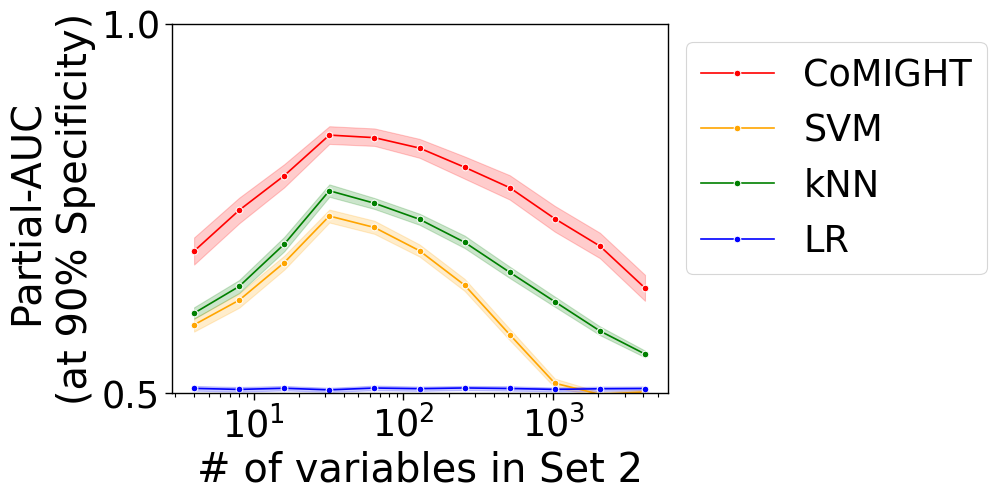

In [40]:
sns.set_context("paper", font_scale=3.0)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    x="n_features_2",
    y="score",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
)

ax.set_ylabel("Partial-AUC \n(at 90% Specificity)")
ax.set_xlabel("# of variables in Set 2")
ax.set(
    ylim=[0.5, 1],
    yticks=[0.5, 1],
)
ax.set_xscale("log")
# ax.set_ylabel(None)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Plotting partial-AUC over sample-sizes

In [41]:
sim_type = "directindirect"

In [42]:
if sim_type == "independent":
    df = pd.read_csv(
        "~/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_independent_model_varying_samples_full.csv",
        index_col=0,
        header=0,
    )
elif sim_type == "collider":
    df = pd.read_csv(
        "~/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_collider_model_varying_samples_full.csv",
        index_col=0,
        header=0,
    )
elif sim_type == "confounder":
    df = pd.read_csv(
        "~/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_confounder_model_varying_samples_full.csv",
        index_col=0,
        header=0,
    )
elif sim_type == "directindirect":
    df = pd.read_csv(
        "~/Desktop/cancer/cv_comight_mv_vs_knn_vs_lr_directindirect_model_varying_samples_full.csv",
        index_col=0,
        header=0,
    )

print(df.shape)
display(df.head())

(600, 7)


,mvrf_pauc,svm_pauc,knn_pauc,lr_pauc,n_samples,n_features_2,noise_dims
0,0.649123,0.505662,0.551196,0.505582,64,4096,90
1,0.604485,0.513557,0.545695,0.520084,128,4096,90
2,0.778885,0.498806,0.572256,0.521652,256,4096,90
3,0.807494,0.500989,0.573175,0.508043,512,4096,90
4,0.863286,0.504738,0.576367,0.495548,1024,4096,90


In [43]:
# melt the dataframe, to make it easier to plot
df.drop(
    [
        "noise_dims",
        # "lr_pauc",
        # "knn_pauc",
        # "mvrf_pauc",
        # "mvrf_pvalue_x2",
        # "lr_pvalue_x2",
        # "knn_pvalue_x2",
        # "mvrf_pvalue_x1",
        # "lr_pvalue_x1",
        # "knn_pvalue_x1",
    ],
    inplace=True,
    axis=1,
)
df = pd.melt(
    df,
    id_vars=["n_features_2", "n_samples"],
    var_name="model",
    value_name="score",
)

name_map = {
    "mvrf_pauc": "CoMIGHT",
    "knn_pauc": "kNN",
    "lr_pauc": "LR",
    "svm_pauc": "SVM",
}
df["model"] = df["model"].map(name_map)

display(df.head())

,n_features_2,n_samples,model,score
0,4096,64,CoMIGHT,0.649123
1,4096,128,CoMIGHT,0.604485
2,4096,256,CoMIGHT,0.778885
3,4096,512,CoMIGHT,0.807494
4,4096,1024,CoMIGHT,0.863286


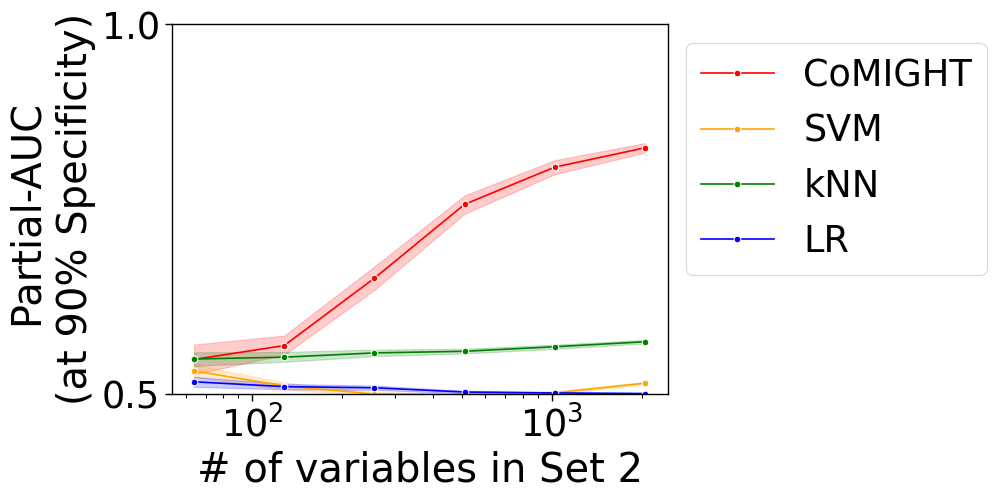

In [44]:
sns.set_context("paper", font_scale=3.0)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "kNN": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    x="n_samples",
    y="score",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="ci",
)

ax.set_ylabel("Partial-AUC \n(at 90% Specificity)")
ax.set_xlabel("# of variables in Set 2")
ax.set(
    ylim=[0.5, 1],
    yticks=[0.5, 1],
)
ax.set_xscale("log")
# ax.set_ylabel(None)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Plotting CMI over sample-sizes

In [224]:
sim_type = "independent"

In [240]:
if sim_type == "independent":
    df = pd.read_csv(
        "~/Desktop/cancer/cmi/cv_comight_mv_vs_knn_vs_lr_independent_model_varying_samples_pvalues.csv",
        index_col=0,
        header=0,
    )
elif sim_type == "collider":
    df = pd.read_csv(
        "~/Desktop/cancer/cmi/cv_comight_mv_vs_knn_vs_lr_collider_model_varying_samples_pvalues.csv",
        index_col=0,
        header=0,
    )
elif sim_type == "confounder":
    df = pd.read_csv(
        "~/Desktop/cancer/cmi/cv_comight_mv_vs_knn_vs_lr_confounder_model_varying_samples_pvalues.csv",
        index_col=0,
        header=0,
    )
elif sim_type == "directindirect":
    df = pd.read_csv(
        "~/Desktop/cancer/cmi/cv_comight_mv_vs_knn_vs_lr_directindirect_model_varying_samples_pvalues.csv",
        index_col=0,
        header=0,
    )

print(df.shape)
display(df.head(-5))

(600, 7)


,ksg_cmi,mvrf_mi,mvrf_pvalue_x2,y_true,n_samples,n_features_2,noise_dims
0,-1.601713e-16,-0.000022,0.730270,[0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1...,64,2048,90
1,4.805140e-16,-0.000821,0.235764,[0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1...,128,2048,90
2,4.805140e-16,-0.000014,0.656344,[1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1...,256,2048,90
3,4.805140e-16,-0.001020,0.272727,[0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1...,512,2048,90
4,4.805140e-16,-0.001016,0.369630,[1 1 0 ... 0 1 0],1024,2048,90
...,...,...,...,...,...,...,...
590,4.805140e-16,-0.000158,0.572428,[1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1...,256,2048,90
591,4.805140e-16,0.000980,0.926074,[1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0...,512,2048,90
592,4.805140e-16,-0.000838,0.332667,[1 0 0 ... 0 0 0],1024,2048,90
593,4.805140e-16,-0.001401,0.246753,[0 0 1 ... 1 0 1],2048,2048,90


In [241]:
# melt the dataframe, to make it easier to plot
df.drop(
    [
        "noise_dims",
        "mvrf_pvalue_x2",
        "y_true",
        "n_features_2",
        # "lr_pauc",
        # "knn_pauc",
        # "mvrf_pauc",
        # "mvrf_pvalue_x2",
        # "lr_pvalue_x2",
        # "knn_pvalue_x2",
        # "mvrf_pvalue_x1",
        # "lr_pvalue_x1",
        # "knn_pvalue_x1",
    ],
    inplace=True,
    axis=1,
)

df = pd.melt(
    df,
    id_vars=["n_samples"],
    var_name="model",
    value_name="score",
)

print(df["model"].unique)
display(df.head())

name_map = {
    "mvrf_pauc": "CoMIGHT",
    "knn_pauc": "kNN",
    "lr_pauc": "LR",
    "svm_pauc": "SVM",
    "ksg_cmi": "KSG",
    "mvrf_mi": "CoMIGHT",
}
df["model"] = df["model"].map(name_map)

# df["score"] = df['score'].where(df['score']>0,0.)
display(df.head())

<bound method Series.unique of 0       ksg_cmi
1       ksg_cmi
2       ksg_cmi
3       ksg_cmi
4       ksg_cmi
         ...   
1195    mvrf_mi
1196    mvrf_mi
1197    mvrf_mi
1198    mvrf_mi
1199    mvrf_mi
Name: model, Length: 1200, dtype: object>


,n_samples,model,score
0,64,ksg_cmi,-1.601713e-16
1,128,ksg_cmi,4.805140e-16
2,256,ksg_cmi,4.805140e-16
3,512,ksg_cmi,4.805140e-16
4,1024,ksg_cmi,4.805140e-16


,n_samples,model,score
0,64,KSG,-1.601713e-16
1,128,KSG,4.805140e-16
2,256,KSG,4.805140e-16
3,512,KSG,4.805140e-16
4,1024,KSG,4.805140e-16


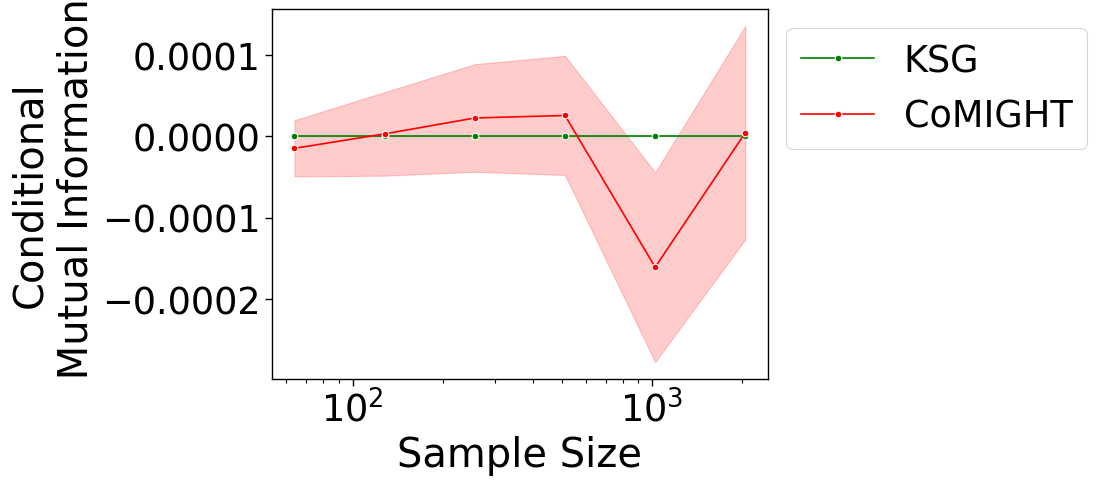

In [242]:
sns.set_context("paper", font_scale=3.0)
fig, ax = plt.subplots()

palette = {"CoMIGHT": "red", "SVM": "orange", "KSG": "green", "LR": "blue"}

ax = sns.lineplot(
    data=df,
    x="n_samples",
    y="score",
    marker="o",
    hue="model",
    ax=ax,
    palette=palette,
    errorbar="se",
)

ax.set_ylabel("Conditional\n Mutual Information")
ax.set_xlabel("Sample Size")
ax.set(
    # ylim=[0.5, 1],
    # yticks=[0.5, 1],
)
ax.set_xscale("log")
# ax.set_ylabel(None)
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()